# Telling birds from airplanes: Learning from images

## 7.1 A dataset of tiny images

In [1]:
from torchvision import datasets
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=False)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False)

The dataset is returned as a subclass of
torch.utils.data.Dataset. We can see that the method-resolution order of our
cifar10 instance includes it as a base class

In [2]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

Looking at figure 7.2, we see what PyTorch Dataset is all about. It
is an object that is required to implement two methods: __len__ and __getitem__.
The former should return the number of items in the dataset; the latter should return
the item, consisting of a sample and its corresponding label (an integer index).2
In practice, when a Python object is equipped with the __len__ method, we can
pass it as an argument to the len Python built-in function

In [3]:
len(cifar10)

50000

![Figure_7.2.png](Images_ch7/Figure_7.2.png)

In [4]:
img, label = cifar10[99]
img, label

(<PIL.Image.Image image mode=RGB size=32x32>, 1)

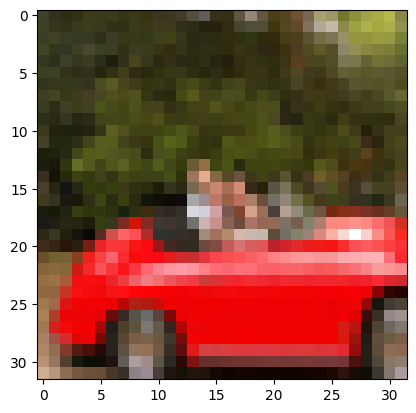

In [5]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()


[transforms] This module defines a set of composable, function-like objects that can be
passed as an argument to a torchvision dataset such as datasets.CIFAR10(…), and
that perform transformations on the data after it is loaded but before it is returned by
__getitem__. We can see the list of available objects as follows:

In [6]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

Among those transforms, we can spot ToTensor, which turns NumPy arrays and PIL
images to tensors. It also takes care to lay out the dimensions of the output tensor as
C × H × W (channel, height, width; just as we covered in chapter 4).

In [7]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [8]:
#We can pass transform as an argument 
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
transform=transforms.ToTensor())

In [9]:
# Rather than image, a tensor is returned
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [10]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

Whereas the values in the original PIL image ranged from 0 to 255 (8 bits per chan-
nel), the ToTensor transform turns the data into a 32-bit floating-point per channel,
scaling the values down from 0.0 to 1.0. Let’s verify that

In [11]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

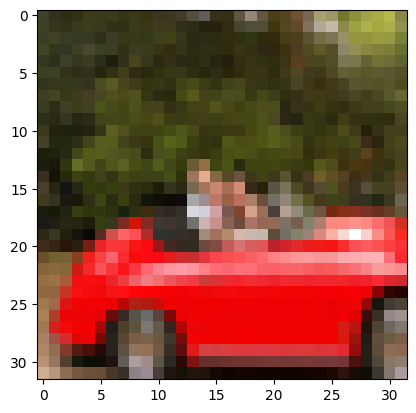

In [12]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

Transforms are really handy because we can chain them using transforms.Compose,
and they can handle normalization and data augmentation transparently, directly in
the data loader. For instance, it’s good practice to normalize the dataset so that each
channel has zero mean and unitary standard deviation. We mentioned this in chapter
4, but now, after going through chapter 5, we also have an intuition for why: by choosing
activation functions that are linear around 0 plus or minus 1 (or 2), keeping the data
in the same range means it’s more likely that neurons have nonzero gradients and, hence, will learn sooner. Also, normalizing each channel so that it has the same
distribution will ensure that channel information can be mixed and updated through
gradient descent using the same learning rate. This is just like the situation in section
5.4.4 when we rescaled the weight to be of the same magnitude as the bias in our
temperature-conversion model.

In [13]:
import torch
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [14]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [15]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [16]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [17]:
transformed_cifar10 = datasets.CIFAR10(
data_path, train=True, download=False,transform=transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.4915, 0.4823, 0.4468),
(0.2470, 0.2435, 0.2616))
]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9806982..2.126078].


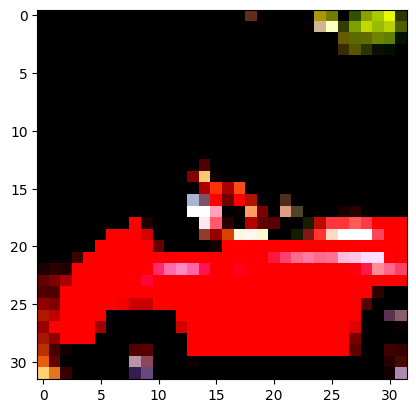

In [18]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

This is because normalization
has shifted the RGB levels outside the 0.0 to 1.0 range and changed the overall magni-
tudes of the channels. All of the data is still there; it’s just that Matplotlib renders it as
black

## 7.2 Distinguishing birds from airplanes

![Figure_7.6.png](Images_ch7/Figure_7.6.png)

Extracting birds and planes from cifar10 dataset and renaming it to cifar2

In [19]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
for img, label in cifar10
if label in [0, 2]]
cifar2_val = [(img, label_map[label])
for img, label in cifar10_val
if label in [0, 2]]

The cifar2 object satisfies the basic requirements for a Dataset—that is, __len__ and
__getitem__ are defined—so we’re going to use that

![Figure_7.7.png](Images_ch7/Figure_7.7.png)

In [20]:
import torch.nn as nn
n_out = 2
model = nn.Sequential(
    nn.Linear(3072,512,),
    nn.Tanh(),
    nn.Linear(512,n_out,)
)

The hidden features represent (learned)
relations between the inputs encoded through the weight matrix. As such, the model
might learn to “compare” vector elements 176 and 208, but it does not a priori focus
on them because it is structurally unaware that these are, indeed (row 5, pixel 16) and
(row 6, pixel 16), and thus adjacent.

In the ideal case, the network would output torch.tensor([1.0, 0.0]) for an air-
plane and torch.tensor([0.0, 1.0]) for a bird. Practically speaking, since our clas-
sifier will not be perfect, we can expect the network to output something in between.
The key realization in this case is that we can interpret our output as probabilities: the
first entry is the probability of “airplane,” and the second is the probability of “bird.”

Casting the problem in terms of probabilities imposes a few extra constraints on
the outputs of our network:
* Each element of the output must be in the [0.0, 1.0] range (a probability of
an outcome cannot be less than 0 or greater than 1).
* The elements of the output must add up to 1.0 (we’re certain that one of the
two outcomes will occur).

Softmax is a function that takes a vector of values and produces another vector of the
same dimension, where the values satisfy the constraints we just listed to represent
probabilities.

In [21]:
def softmax(x):
    return torch.exp(x)/torch.exp(x).sum()

x = torch.tensor([1.0,2.0,3.0])
print(softmax(x))

tensor([0.0900, 0.2447, 0.6652])


![Figure_7.8.png](Images_ch7/Figure_7.8.png)

In [22]:
# Works like expected
softmax(x).sum()

tensor(1.)

Softmax is a monotone function, in that lower values in the input will correspond to
lower values in the output. However, it’s not scale invariant, in that the ratio between
values is not preserved. In fact, the ratio between the first and second elements of the
input is 0.5, while the ratio between the same elements in the output is 0.3678. This is
not a real issue, since the learning process will drive the parameters of the model in a
way that values have appropriate ratios.

In [23]:
softmax = nn.Softmax(dim=0)
x = torch.tensor([[1.0, 2.0, 3.0],
[1.0, 2.0, 3.0]])
softmax(x)

tensor([[0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000]])

In [24]:
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0],
[1.0, 2.0, 3.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In this case, we have two input vectors in two rows (just like when we work with
batches), so we initialize nn.Softmax to operate along dimension 1.
Excellent! We can now add a softmax at the end of our model, and our network
will be equipped to produce probabilities:

In [25]:
model = nn.Sequential(
nn.Linear(3072, 512),
nn.Tanh(),
nn.Linear(512, 2),
nn.Softmax(dim=1)
)

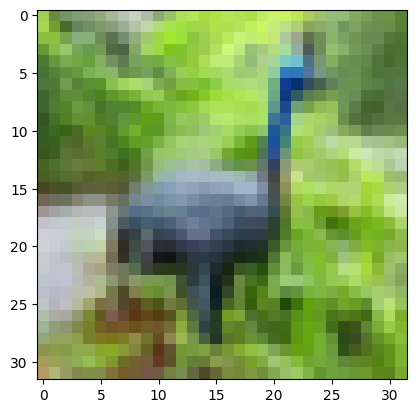

In [26]:
img, _ = cifar2[0]
img = to_tensor(img)
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [27]:
img_batch = img.view(-1).unsqueeze(0)

In [28]:
out = model(img_batch)
out

tensor([[0.5508, 0.4492]], grad_fn=<SoftmaxBackward0>)

So, we got probabilities! Well, we know we shouldn’t get too excited: the weights and
biases of our linear layers have not been trained at all. Their elements are initialized
randomly by PyTorch between –1.0 and 1.0.

In addition, while we know which output probability is supposed to be which
(recall our class_names), our network has no indication of that. Is the first entry “air-
plane” and the second “bird,” or the other way around? The network can’t even tell
that at this point. It’s the loss function that associates a meaning with these two num-
bers, after backpropagation.

Thus,
after training, we will be able to get the label as an index by computing the argmax of
the output probabilities: that is, the index at which we get the maximum probability.
Conveniently, when supplied with a dimension, torch.max returns the maximum ele-
ment along that dimension as well as the index at which that value occurs. In our case,
we need to take the max along the probability vector (not across batches), therefore,
dimension 1:

In [29]:
_, index = torch.max(out, dim=1)
index

tensor([0])

e want a loss function that
is very high when the likelihood is low: so low that the alternatives have a higher prob-
ability. Conversely, the loss should be low when the likelihood is higher than the alter-
natives, and we’re not really fixated on driving the probability up to 1.
There’s a loss function that behaves that way, and it’s called negative log likelihood
(NLL). It has the expression NLL = - sum(log(out_i[c_i])), where the sum is taken
over N samples and c_i is the correct class for sample i.

![Figure_7.9.png](Images_ch7/Figure_7.9.png)

Summing up, our loss for classification can be computed as follows. For each sam-
ple in the batch:
1. Run the forward pass, and obtain the output values from the last (linear) layer.
2. Compute their softmax, and obtain probabilities.
3. Take the predicted probability corresponding to the correct class (the likeli-
hood of the parameters). Note that we know what the correct class is because
it’s a supervised problem—it’s our ground truth.
4. Compute its logarithm, slap a minus sign in front of it, and add it to the loss.

However (gotcha
ahead), as opposed to what you might expect, it does not take probabilities but rather
takes a tensor of log probabilities as input. It then computes the NLL of our model
given the batch of data. There’s a good reason behind the input convention: taking
the logarithm of a probability is tricky when the probability gets close to zero. The
workaround is to use nn.LogSoftmax instead of nn.Softmax, which takes care to make
the calculation numerically stable.

In [30]:
model = nn.Sequential(
nn.Linear(3072, 512),
nn.Tanh(),
nn.Linear(512, 2),
nn.LogSoftmax(dim=1))

In [31]:
loss = nn.NLLLoss()

The loss takes the output of nn.LogSoftmax for a batch as the first argument and a
tensor of class indices (zeros and ones, in our case) as the second argument. We can
now test it with our birdie:

In [32]:
img, label = cifar2[0]
img = to_tensor(img)
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.6863, grad_fn=<NllLossBackward0>)

In [33]:
cifar2 = [(to_tensor(img), label) for img, label in cifar2]

In [34]:
cifar2_val = [(to_tensor(img), label) for img, label in cifar2_val]

In [35]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce GTX 1650 Ti'

We’re ready to bring back the training loop we wrote in chapter 5 and see
how it trains

In [36]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# model = nn.Sequential(
# nn.Linear(3072, 512),
# nn.Tanh(),
# nn.Linear(512, 2),
# nn.LogSoftmax(dim=1))
# learning_rate = 1e-2
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# loss_fn = nn.NLLLoss()
# n_epochs = 100
# 
# for epoch in range(n_epochs):
#     for img, label in cifar2:
#         #img = to_tensor(img)
#         out = model(img.view(-1).unsqueeze(0))
#         loss = loss_fn(out, torch.tensor([label]))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         
#     print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

![Figure_7.12.png](Images_ch7/Figure_7.12.png)

By shuffling samples
at each epoch and estimating the gradient on one or (preferably, for stability) a few
samples at a time, we are effectively introducing randomness in our gradient descent.
Remember SGD? It stands for stochastic gradient descent, and this is what the S is about:
working on small batches (aka minibatches) of shuffled data. It turns out that following
gradients estimated over minibatches, which are poorer approximations of gradients
estimated across the whole dataset, helps convergence and prevents the optimization
process from getting stuck in local minima it encounters along the way. As depicted in
figure 7.13, gradients from minibatches are randomly off the ideal trajectory, which is
part of the reason why we want to use a reasonably small learning rate. Shuffling the
dataset at each epoch helps ensure that the sequence of gradients estimated over mini-
batches is representative of the gradients computed across the full dataset.
Typically, minibatches are a constant size that we need to set prior to training, just
like the learning rate. These are called hyperparameters, to distinguish them from the
parameters of a model.

![Figure_7.13.png](Images_ch7/Figure_7.13.png)

In our training code, we chose minibatches of size 1 by picking one item at a time from
the dataset. The torch.utils.data module has a class that helps with shuffling and
organizing the data in minibatches: DataLoader. The job of a data loader is to sample
minibatches from a dataset, giving us the flexibility to choose from different sampling
strategies. A very common strategy is uniform sampling after shuffling the data at each
epoch. Figure 7.14 shows the data loader shuffling the indices it gets from the Dataset.

![Figure_7.14.png](Images_ch7/Figure_7.14.png)


Let’s see how this is done. At a minimum, the DataLoader constructor takes a Dataset
object as input, along with batch_size and a shuffle Boolean that indicates whether
the data needs to be shuffled at the beginning of each epoch

In [37]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
shuffle=True)

A DataLoader can be iterated over, so we can use it directly in the inner loop of our
new training code:

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
shuffle=True)

model = nn.Sequential(
nn.Linear(3072, 512),
nn.Tanh(),
nn.Linear(512, 2),
nn.LogSoftmax(dim=1))

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss))) # Due to the shuffling, this now prints the loss for a random batch—clearly something we want to improve in chapter 8.

Epoch: 0, Loss: 0.401985
Epoch: 1, Loss: 0.559435
Epoch: 2, Loss: 0.398818
Epoch: 3, Loss: 0.334548
Epoch: 4, Loss: 0.454578
Epoch: 5, Loss: 0.493334
Epoch: 6, Loss: 0.573351
Epoch: 7, Loss: 0.392507
Epoch: 8, Loss: 0.298982
Epoch: 9, Loss: 0.486874
Epoch: 10, Loss: 0.199161
Epoch: 11, Loss: 0.519012
Epoch: 12, Loss: 0.489312
Epoch: 13, Loss: 0.444311
Epoch: 14, Loss: 0.529078
Epoch: 15, Loss: 0.484157
Epoch: 16, Loss: 0.506964
Epoch: 17, Loss: 0.556204
Epoch: 18, Loss: 0.410549
Epoch: 19, Loss: 0.182637
Epoch: 20, Loss: 0.484031
Epoch: 21, Loss: 0.315931
Epoch: 22, Loss: 0.361624
Epoch: 23, Loss: 0.402640
Epoch: 24, Loss: 0.640483
Epoch: 25, Loss: 0.517913
Epoch: 26, Loss: 0.226128
Epoch: 27, Loss: 0.270764
Epoch: 28, Loss: 0.425854
Epoch: 29, Loss: 0.281471
Epoch: 30, Loss: 0.677027
Epoch: 31, Loss: 0.369568
Epoch: 32, Loss: 0.461775
Epoch: 33, Loss: 0.529929
Epoch: 34, Loss: 0.398425
Epoch: 35, Loss: 0.379440
Epoch: 36, Loss: 0.214725
Epoch: 37, Loss: 0.459547
Epoch: 38, Loss: 0.477

At each inner iteration, imgs is a tensor of size 64 × 3 × 32 × 32—that is, a minibatch of
64 (32 × 32) RGB images—while labels is a tensor of size 64 containing label indices.

In [39]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)

Accuracy: %f 0.8315


In [40]:
# We can certainly add some bling to our model by including more layers, which will
# increase the model’s depth and capacity. One rather arbitrary possibility is
model = nn.Sequential(
nn.Linear(3072, 1024),
nn.Tanh(),
nn.Linear(1024, 512),
nn.Tanh(),
nn.Linear(512, 128),
nn.Tanh(),
nn.Linear(128, 2),
nn.LogSoftmax(dim=1))

In [41]:
# Note that the numbers will be exactly the same as with nn.LogSoftmax and nn.NLLLoss.
# It’s just more convenient to do it all in one pass, with the only gotcha being that the out-
# put of our model will not be interpretable as probabilities (or log probabilities). We’ll
# need to explicitly pass the output through a softmax to obtain those.

model = nn.Sequential(
nn.Linear(3072, 1024),
nn.Tanh(),
nn.Linear(1024, 512),
nn.Tanh(),
nn.Linear(512, 128),
nn.Tanh(),
nn.Linear(128, 2))
loss_fn = nn.CrossEntropyLoss()


PyTorch offers a quick way to determine how many parameters a model has
through the parameters() method of nn.Model (the same method we use to provide
the parameters to the optimizer). To find out how many elements are in each tensor
instance, we can call the numel method.

In [42]:
numel_list = [p.numel()
for p in model.parameters()
if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

The number of parameters in our first model is roughly half that in our latest model.
Well, from the list of individual parameter sizes, we start having an idea what’s
responsible: the first module, which has 1.5 million parameters. In our full network,
we had 1,024 output features, which led the first linear module to have 3 million
parameters. This shouldn’t be unexpected: we know that a linear layer computes y =
weight * x + bias, and if x has length 3,072 (disregarding the batch dimension for
simplicity) and y must have length 1,024, then the weight tensor needs to be of size
1,024 × 3,072 and the bias size must be 1,024. And 1,024 * 3,072 + 1,024 = 3,146,752,
as we found earlier:

In [43]:
linear = nn.Linear(3072, 1024)
linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

What is this telling us? That our neural network won’t scale very well with the number
of pixels. What if we had a 1,024 × 1,024 RGB image? That’s 3.1 million input values.
Even abruptly going to 1,024 hidden features (which is not going to work for our clas-
sifier), we would have over 3 billion parameters. Using 32-bit floats, we’re already at 12
GB of RAM, and we haven’t even hit the second layer, much less computed and stored
the gradients. That’s just not going to fit on most present-day GPUs.

An airplane flying in the sky captured in a 32 × 32 image will be very roughly similar to
a dark, cross-like shape on a blue background. A fully connected network as in figure
7.15 would need to learn that when pixel 0,1 is dark, pixel 1,1 is also dark, and so on,
that’s a good indication of an airplane. This is illustrated in the top half of figure 7.16.
However, shift the same airplane by one pixel or more as in the bottom half of the fig-
ure, and the relationships between pixels will have to be relearned from scratch: this
time, an airplane is likely when pixel 0,2 is dark, pixel 1,2 is dark, and so on. In more
technical terms, a fully connected network is not translation invariant. This means a
network that has been trained to recognize a Spitfire starting at position 4,4 will not
be able to recognize the exact same Spitfire starting at position 8,8.

![Figure_7.16.png](Images_ch7/Figure_7.16.png)


We’ve created a model that allows for relating every pixel to every other pixel in
the image, regardless of their spatial arrangement. We have a reasonable assumption
that pixels that are closer together are in theory a lot more related, though. This
means we are training a classifier that is not translation-invariant, so we’re forced to
use a lot of capacity for learning translated replicas if we want to hope to do well on
the validation set. There has to be a better way, right?

## Summary

* Computer vision is one of the most extensive applications of deep learning.
* Several datasets of annotated images are publicly available; many of them can
be accessed via torchvision.
* Datasets and DataLoaders provide a simple yet effective abstraction for loading
and sampling datasets.
* For a classification task, using the softmax function on the output of a network
produces values that satisfy the requirements for being interpreted as probabili-
ties. The ideal loss function for classification in this case is obtained by using the
output of softmax as the input of a non-negative log likelihood function. The
combination of softmax and such loss is called cross entropy in PyTorch.
* Nothing prevents us from treating images as vectors of pixel values, dealing
with them using a fully connected network, just like any other numerical data.
However, doing so makes it much harder to take advantage of the spatial rela-
tionships in the data.
* Simple models can be created using nn.Sequential.